#Building Decision Trees that Classify NFL Players

##Alex Kerr

###Introduction

I want to try building decision trees for myself after talking about them in my solid-state chemistry paper review.  I quickly settled on classifying NFL offensive skill players by position.  This isn't a terribly compelling problem and I don't expect it to be too difficult but it should provide me with the experience of building the trees.  The data is not very abstract so it should be easy for myself and others to comprehend.

###What Do We Need

We need a python module that can import NFL stats.  I have chosen `nflgame` and it is required if you want to run this notebook. We also need a way to visualize the trees once they are done.  To do this I had to install `graphviz` and use the `sklearn` tool used detailed here: http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html#sklearn.tree.export_graphviz

Lets import all player stats from the 2014 season.  I am choosing a single season's worth of players and player stats.  2014 was the last complete season.

In [27]:
import numpy as np
import nflgame

weeks = range(1,18) #list of every week in the regular season
season = nflgame.games(2014, weeks) 
players = nflgame.combine(season)

print players

[R.Wilson, M.Lynch, R.Turbin, P.Harvin, Z.Miller, D.Baldwin, D.Coleman, L.Willson, J.Kearse, R.Lockette, E.Thomas, S.Hauschka, J.Ryan, T.McDaniel, K.Wright, B.Maxwell, B.Irvin, C.Avril, K.Chancellor, M.Smith, M.Burley, O.Schofield, K.Williams, B.Wagner, M.Bennett, J.Lane, A.Rodgers, D.Harris, E.Lacy, J.Kuhn, J.Starks, A.Quarless, R.Cobb, J.Nelson, H.Clinton-Dix, D.Sherrod, M.Crosby, T.Masthay, M.Hyde, S.Shields, B.Jones, A.Hawk, N.Perry, C.Matthews, T.Williams, C.Hayward, M.Neal, M.Burnett, D.Jones, J.Peppers, M.Daniels, M.Ryan, D.Freeman, A.Smith, J.Rodgers, S.Jackson, H.Douglas, R.White, JulioJones, D.Hester, L.Toilolo, J.Bartu, M.Bryant, M.Bosher, S.Maponga, P.Worrilow, K.Ishmael, T.Jackson, R.Alford, W.Moore, O.Umenyiora, K.Biermann, J.Massaquoi, D.Lowery, J.Babineaux, R.McClain, D.Trufant, D.Brees, B.Cooks, K.Robinson, M.Ingram, P.Thomas, T.Cadet, B.Watson, M.Colston, J.Graham, C.White, S.Graham, T.Morstead, J.Byrd, T.Walker, K.Vaccaro, C.Lofton, D.Hawthorne, A.Hicks, R.Bush, K.Le

It appears we have a list of every player on a roster in the 2014 season.  It seems to be sorted by team: Seattle, Green Bay, then Atlanta, etc.

We need to decide on stats that we think are important in classifying players by position.  My first considerations are: `passing yards`, `rushing yards`, `receiving yards`, `passing TDs`, `rushing TDs`, and `receiving TDs`.

In [28]:
dataList = []

for p in players:
    a = p.player.position
    
    if a == 'QB' or a == 'RB' or a == 'WR' or a == 'TE':
        dataList.append([str(p.name), str(a), p.passing_yds, p.rushing_yds, p.receiving_yds, p.passing_tds, p.rushing_tds, p.receiving_tds])
        
print dataList

[['R.Wilson', 'QB', 3475, 849, 17, 20, 6, 0], ['M.Lynch', 'RB', 0, 1310, 367, 0, 13, 4], ['R.Turbin', 'RB', 0, 306, 186, 0, 0, 2], ['P.Harvin', 'WR', 0, 202, 483, 0, 1, 1], ['D.Baldwin', 'WR', 0, 8, 825, 0, 0, 3], ['L.Willson', 'TE', 0, 0, 362, 0, 0, 3], ['J.Kearse', 'WR', 17, 15, 537, 0, 0, 1], ['R.Lockette', 'WR', 0, 2, 195, 0, 0, 2], ['A.Rodgers', 'QB', 4381, 269, 0, 38, 2, 0], ['E.Lacy', 'RB', 0, 1139, 427, 0, 9, 4], ['J.Starks', 'RB', 0, 333, 140, 0, 2, 0], ['A.Quarless', 'TE', 0, 0, 323, 0, 0, 3], ['R.Cobb', 'WR', 0, 37, 1287, 0, 0, 12], ['J.Nelson', 'WR', 0, 0, 1519, 0, 0, 13], ['M.Ryan', 'QB', 4694, 145, 0, 28, 0, 0], ['D.Freeman', 'RB', 0, 248, 225, 0, 1, 1], ['A.Smith', 'RB', 0, 144, 222, 0, 2, 3], ['J.Rodgers', 'RB', 0, 217, 173, 0, 1, 1], ['H.Douglas', 'WR', 0, 0, 556, 0, 0, 2], ['R.White', 'WR', 0, 0, 921, 0, 0, 7], ['JulioJones', 'WR', 0, 1, 1593, 0, 0, 6], ['D.Hester', 'WR', 0, 36, 504, 0, 1, 2], ['L.Toilolo', 'TE', 0, 0, 238, 0, 0, 2], ['D.Brees', 'QB', 4952, 68, 1, 33,

We now have a list of every player listed as either a `QB`,`RB`,`WR`, or `TE`.  You can see that a lot of players are listed that accumulated very little or no stats.  It appears there is no stat to sort out players who didn't play many downs.  For now I will stick with this data set.

Now we need to put the data in a form we can use.  It is also preferable we use `numpy` arrays.

In [29]:
targetDict = {'QB':0, 'RB':1, 'WR':2, 'TE':3}
featureNames = ['passing yds', 'rushing yds', 'receiving yds', 'passing tds', 'rushing tds', 'receiving tds']
targetNames = np.array(['QB', 'RB', 'WR', 'TE'])

#size of dataList, and number of descriptors
size = len(dataList)
numDes = 6 #pass yds, rush yds, etc.

X = np.zeros((size,numDes), dtype=np.int)
Y = np.zeros(size, dtype=np.int)

#fill X, Y with data

for count,datum in enumerate(dataList):
    X[count] = np.array(datum[-numDes:])
    Y[count] = targetDict[datum[1]]
    
print X
print Y

[[3475  849   17   20    6    0]
 [   0 1310  367    0   13    4]
 [   0  306  186    0    0    2]
 ..., 
 [   0   18   68    0    0    1]
 [   0    0    0    0    0    0]
 [ 177    9    0    0    0    0]]
[0 1 1 2 2 3 2 2 0 1 1 3 2 2 0 1 1 1 2 2 2 2 3 0 2 1 1 3 2 3 0 1 1 2 2 3 3
 2 2 0 2 1 2 1 2 3 3 0 1 1 3 2 2 1 0 1 1 1 2 2 0 1 1 1 2 2 3 0 1 1 2 3 2 3
 3 2 0 1 1 2 3 3 1 1 2 3 2 2 0 1 3 3 2 2 2 2 1 0 1 1 1 2 2 2 3 3 0 0 1 1 1
 2 2 3 3 2 0 1 3 2 2 2 1 0 1 1 3 2 2 3 2 0 1 1 1 2 3 2 2 0 1 1 1 2 3 2 0 1
 2 1 3 3 2 3 2 2 0 0 2 2 1 1 2 3 3 3 0 1 1 2 1 3 3 2 2 0 2 1 2 2 1 2 2 3 0
 1 1 2 3 2 2 2 0 1 1 2 3 3 3 2 0 1 1 2 3 2 2 2 0 2 1 3 2 3 2 0 1 3 3 2 2 2
 0 2 1 1 1 3 2 2 0 1 1 3 3 2 2 0 1 1 2 2 2 2 3 2 0 1 1 1 2 2 2 3 3 2 3 3 2
 1 0 2 3 0 2 2 3 2 3 2 0 3 1 3 0 1 2 3 2 2 3 3 2 2 2 2 3 3 3 3 1 0 2 0 1 3
 1 3 1 2 2 0 2 0 2 2 1 0 2 1 1 2 1 0 3 2 0 3 0 0 3 2 0 0 2 2 2 3 3 0 1 2 3
 1 2 3 1 2 2 2 2 2 3 1 2 2 3 3 2 2 1 3 0 2 3 3 0 1 1 2 1 1 2 0 3 2 0 0 2 0
 1 3 0 0 3 1 0 0 2 3 3 1 0 2 3 2 2 2 1 0 3 3

Looks like we're ready to build the trees.  Above we have `X` which will be our training data, and `Y` which are the  activity values for each of the data points in X, indexed the same way.

In [30]:
from sklearn import tree

#create a tree object then train/fit it with the data
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X,Y)

In [31]:
tree.export_graphviz(clf, out_file='tree.dot', feature_names=featureNames, class_names=targetNames)

This creates a `.dot` file in the same folder as this notebook.  After words I had to do the below on my terminal:

\$ dot -Tps tree.dot -o tree.ps     (PostScript format)

\$ dot -Tpng tree.dot -o tree.png  (PNG format)

Then I import the image below


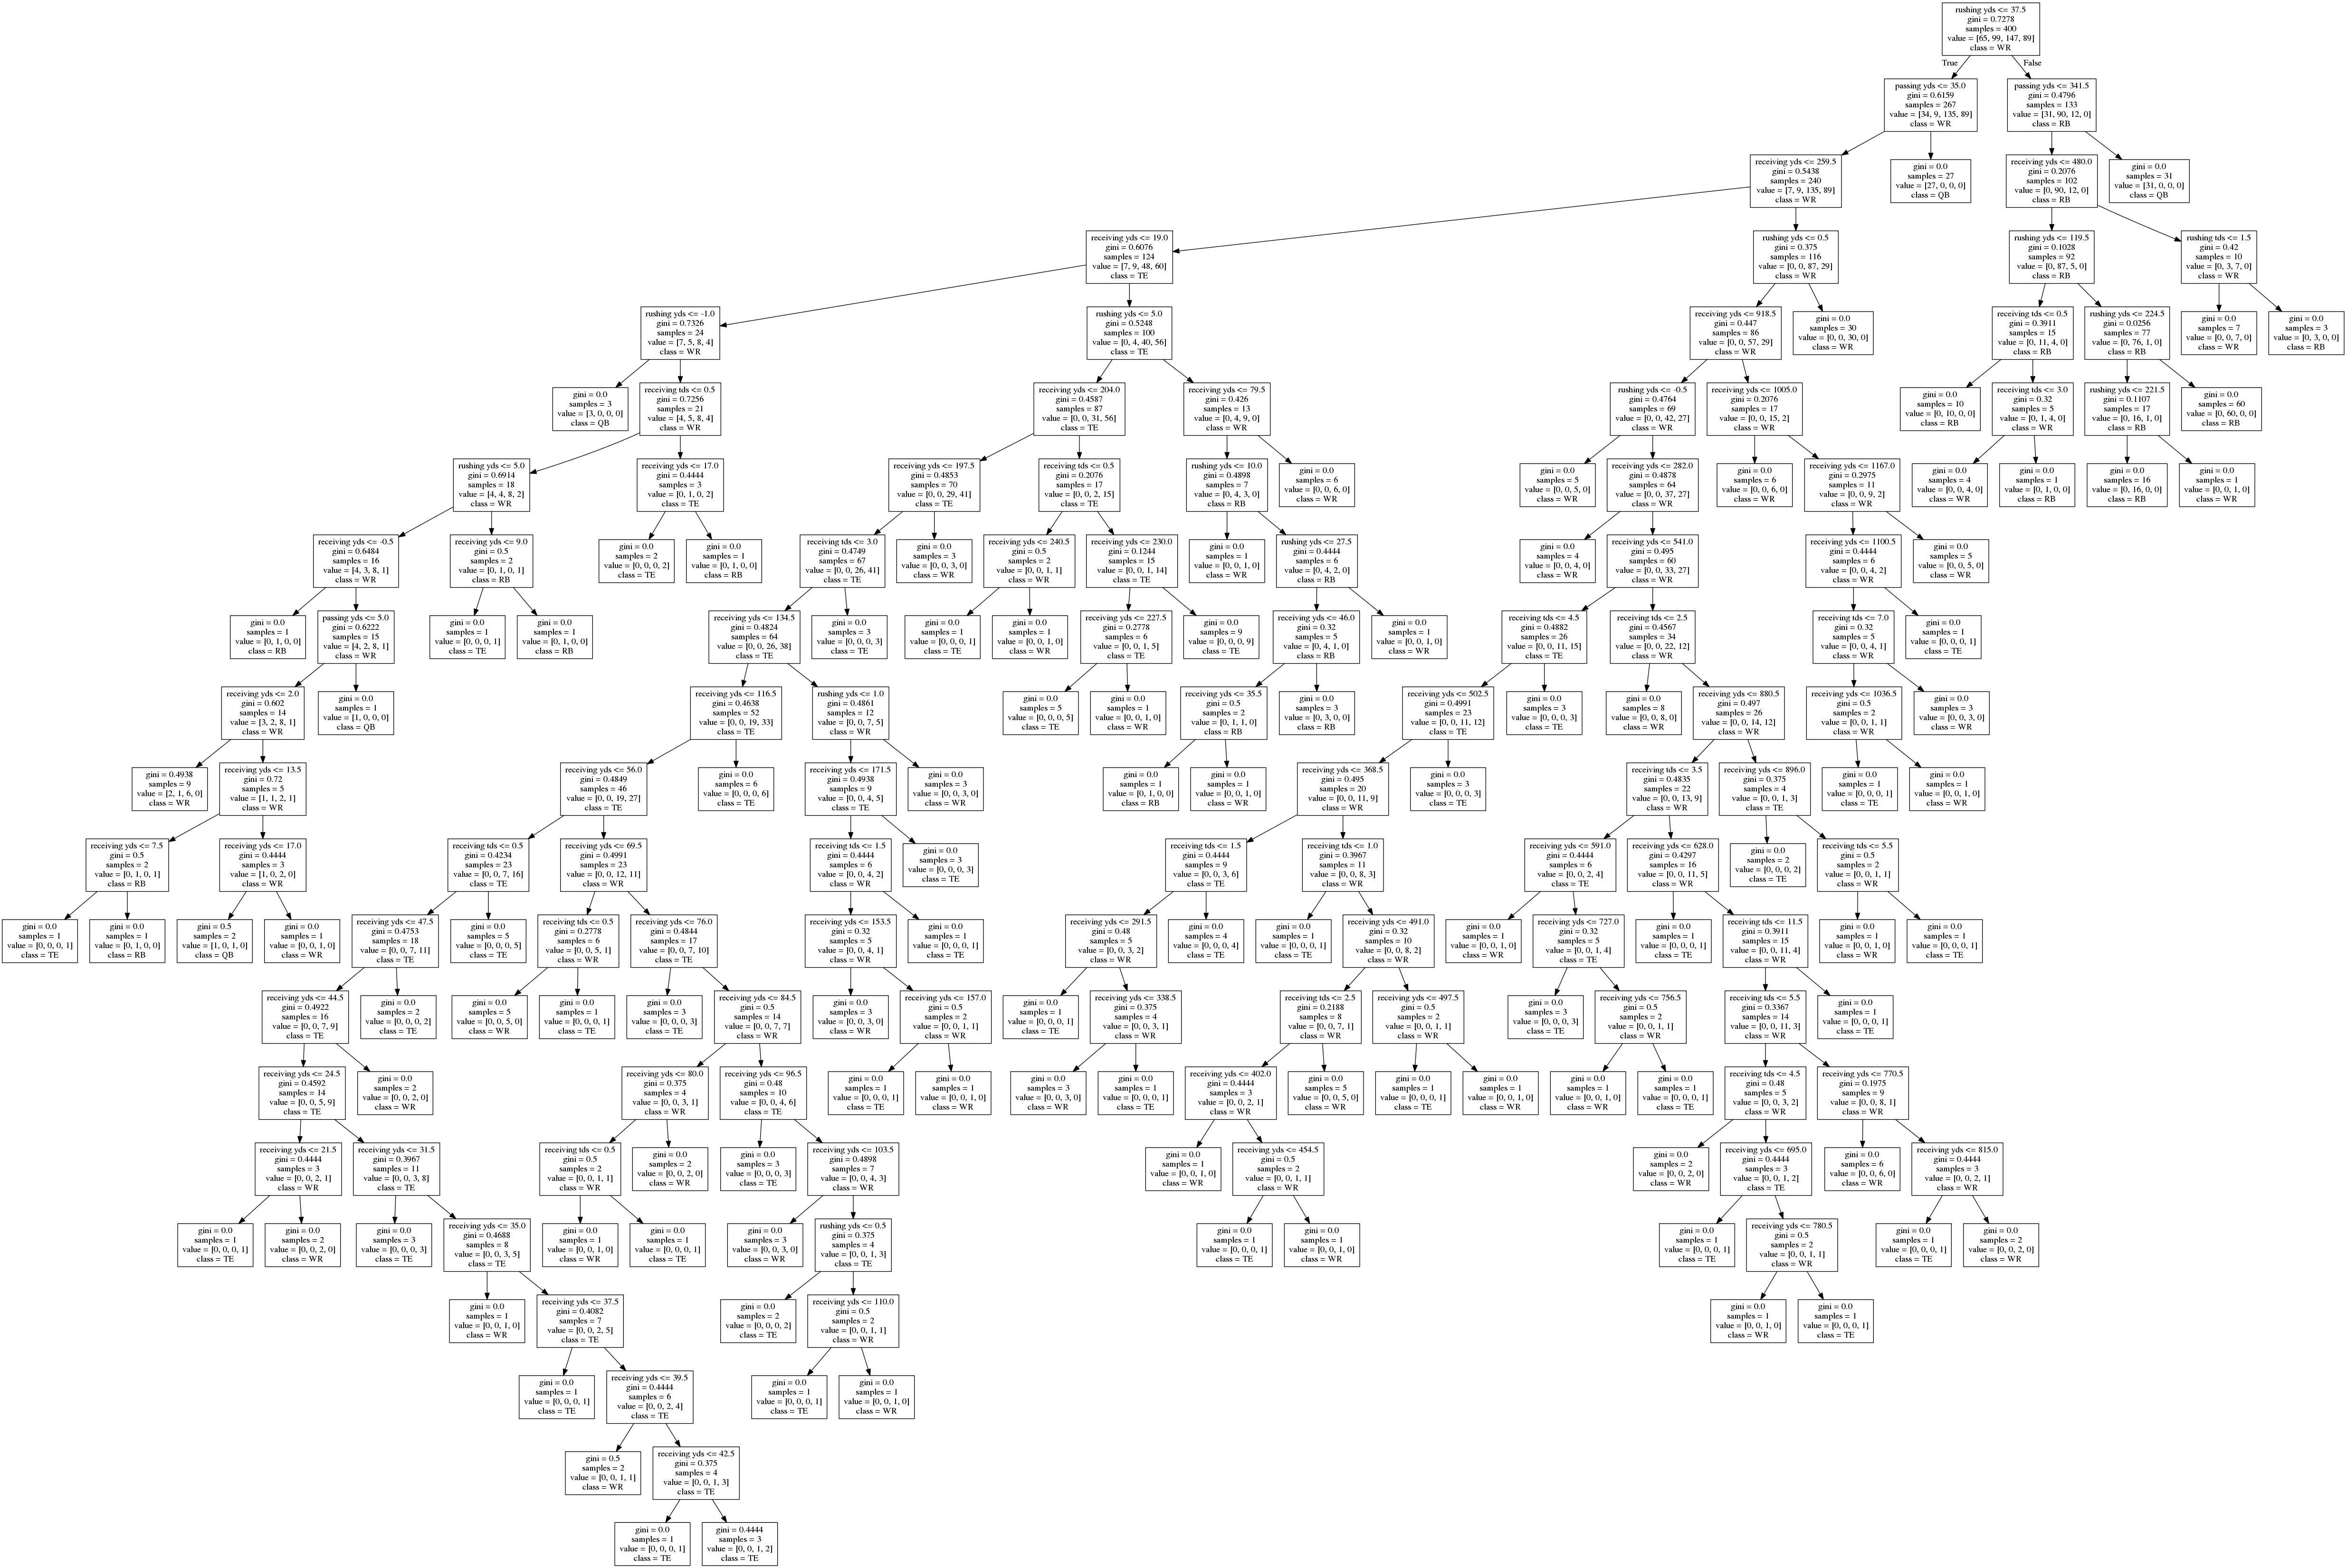

In [32]:
from IPython.display import Image
Image(filename='tree.png')

As you can see this decision tree is very convoluted.  We need to fix this.

We can try simplifying the data.  Let's cut out tight ends in our data list and only include players with a certain total yardage.

In [33]:
dataList = []

for p in players:
    a = p.player.position
    
    if a == 'QB' or a == 'RB' or a == 'WR':
        
        passy = p.passing_yds
        rushy = p.rushing_yds
        recey = p.receiving_yds
        
        totalyds = passy + rushy + recey
        
        if totalyds >= 100:
            dataList.append([str(p.name), str(a), p.passing_yds, p.rushing_yds, p.receiving_yds, p.passing_tds, p.rushing_tds, p.receiving_tds])
        else:
            pass
    else:
        pass
        
#print dataList

Our list is smaller and we no longer have data points that I think confused our tree building algorithms.

Lets redo some of the above code.

In [34]:
targetDict = {'QB':0, 'RB':1, 'WR':2}
featureNames = ['passing yds', 'rushing yds', 'receiving yds', 'passing tds', 'rushing tds', 'receiving tds']
targetNames = ['QB', 'RB', 'WR']

#size of dataList, and number of descriptors
size = len(dataList)
numDes = 6 #pass yds, rush yds, etc.

X = np.zeros((size,numDes), dtype=np.int)
Y = np.zeros(size, dtype=np.int)

#fill X, Y with data

for count,datum in enumerate(dataList):
    X[count] = np.array(datum[-numDes:])
    Y[count] = targetDict[datum[1]]
    
print X
print Y

[[3475  849   17   20    6    0]
 [   0 1310  367    0   13    4]
 [   0  306  186    0    0    2]
 ..., 
 [   0    0  158    0    0    0]
 [ 435   35    0    2    0    0]
 [ 177    9    0    0    0    0]]
[0 1 1 2 2 2 2 0 1 1 2 2 0 1 1 1 2 2 2 2 0 2 1 1 2 0 1 1 2 2 2 2 0 2 1 2 1
 2 0 1 1 2 2 0 1 1 1 2 2 0 1 1 1 2 2 0 1 1 2 2 2 0 1 1 1 1 2 2 2 0 1 2 2 2
 2 1 0 1 1 2 2 2 0 0 1 1 1 2 2 0 1 2 2 1 0 1 1 2 2 2 0 1 1 1 2 2 2 0 1 1 2
 2 0 1 2 1 2 2 2 0 0 2 2 1 1 2 0 1 2 1 2 2 0 2 1 2 1 2 2 0 1 1 2 2 2 0 1 1
 2 2 0 1 1 2 2 2 2 0 2 1 2 0 1 2 2 0 2 1 1 1 2 2 0 1 1 2 2 0 1 1 2 2 2 2 2
 0 1 1 2 2 2 2 0 2 0 2 2 0 1 0 1 2 2 2 2 2 1 2 0 1 1 2 2 0 2 0 2 0 1 2 1 0
 0 0 0 2 2 0 1 2 2 2 2 2 1 2 2 1 2 1 1 1 2 0 2 2 1 0 0 1 2 2 0 0 2 0 0]


In [35]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X,Y)

In [36]:
tree.export_graphviz(clf, out_file='tree2.dot', feature_names=featureNames, class_names=targetNames)

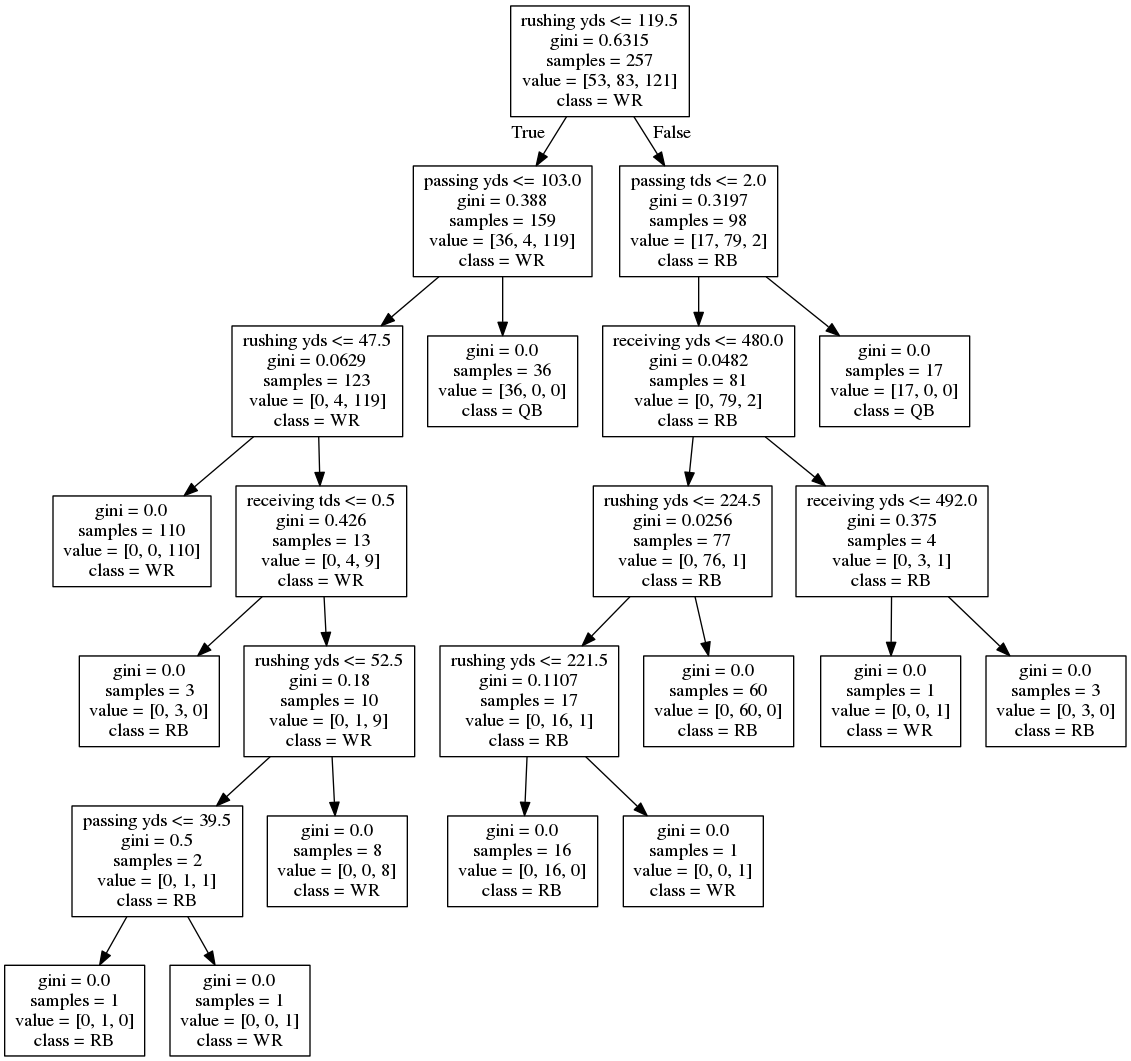

In [37]:
from IPython.display import Image
Image(filename='tree2.png')

This is much better, but I still think this is too convoluted.  I was expecting a simpler tree.  I wonder if the algorithm is being forced to use all the descriptors?  Let's try one more time with just the touchdown stats.

In [38]:
targetDict = {'QB':0, 'RB':1, 'WR':2}
featureNames = ['passing tds', 'rushing tds', 'receiving tds']
targetNames = ['QB', 'RB', 'WR']

#size of dataList, and number of descriptors
size = len(dataList)
numDes = 3 #DIFFERENT than befoore

X = np.zeros((size,numDes), dtype=np.int)
Y = np.zeros(size, dtype=np.int)

#fill X, Y with data

for count,datum in enumerate(dataList):
    X[count] = np.array(datum[-numDes:])
    Y[count] = targetDict[datum[1]]
    
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X,Y)

tree.export_graphviz(clf, out_file='tree3.dot', feature_names=featureNames, class_names=targetNames)

After generating the image...

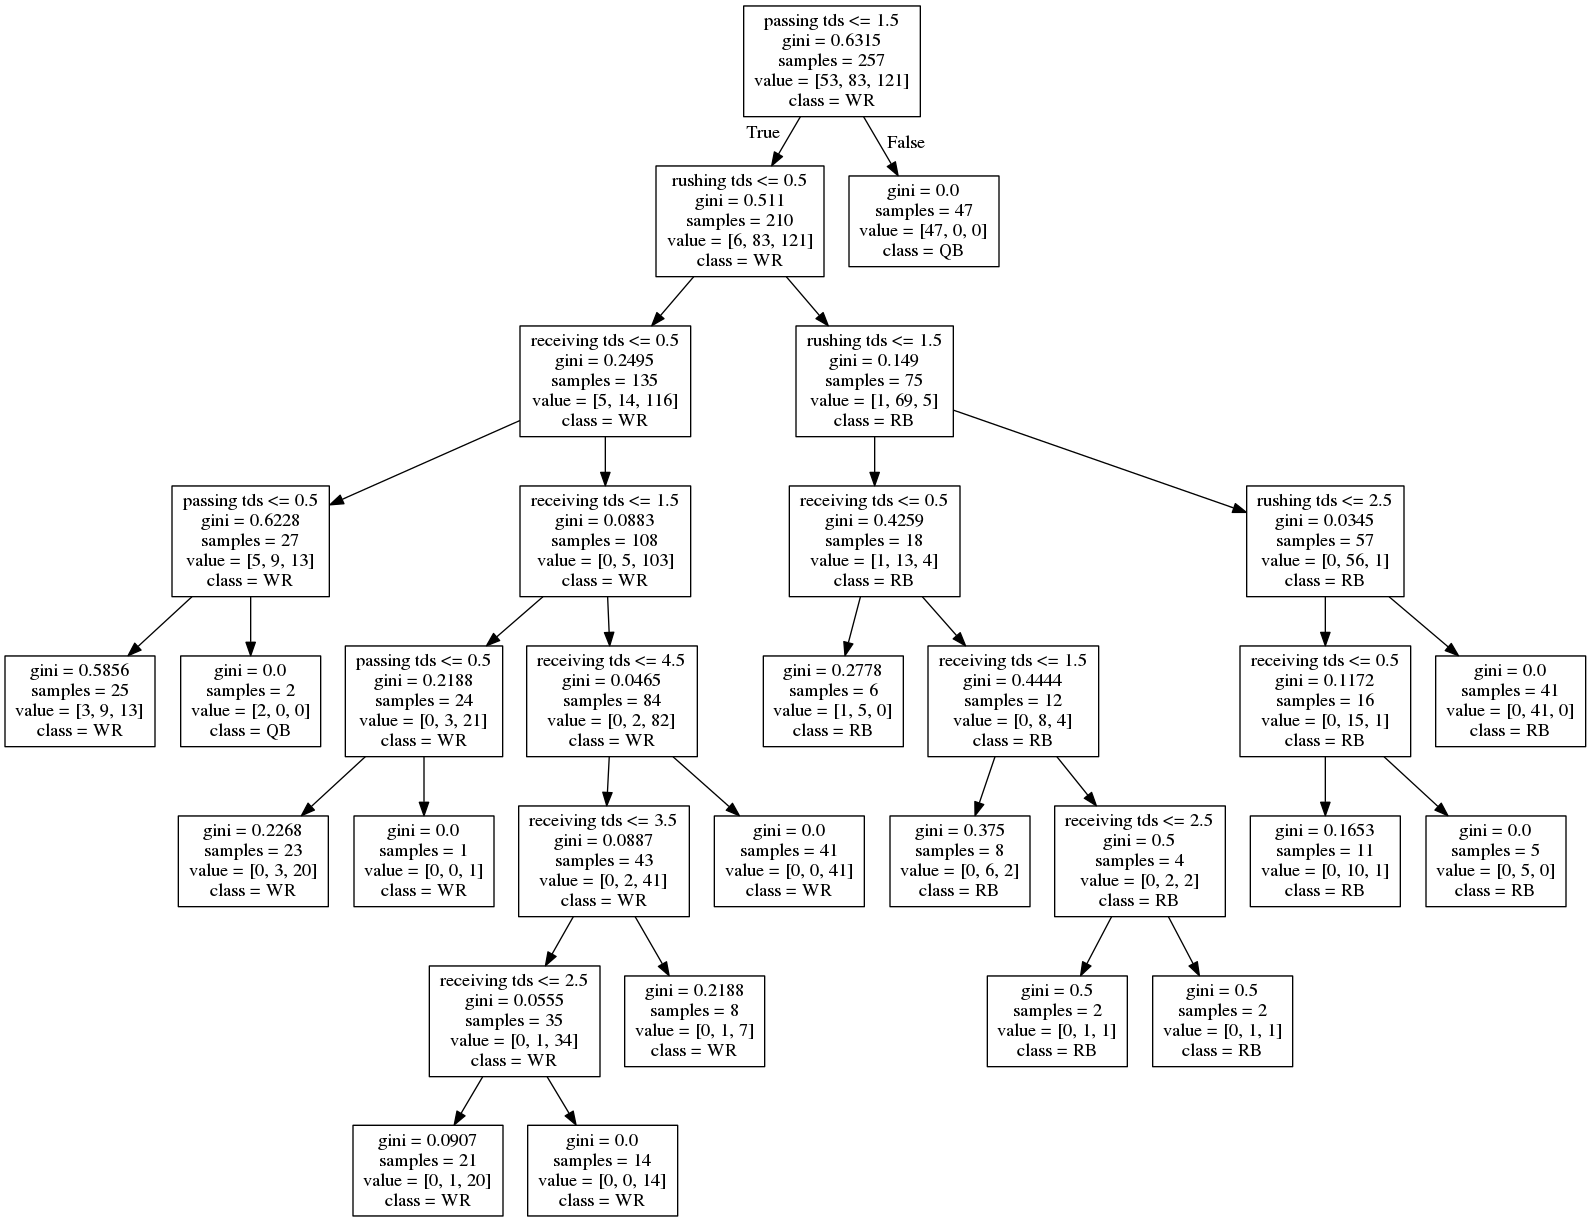

In [39]:
from IPython.display import Image
Image(filename='tree3.png')

From here it is clear that I have to give constraints to the `DecisionTreeClassifier` object to get the kind of tree I want because this tree is actually more complicated than the last.  Let's use the simplified data again, but build a different object.

In [40]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 2)
clf = clf.fit(X,Y)

#here I specified that I want to pick attributes using informational entropy and that the tree cannot be more than 2 nodes deep

tree.export_graphviz(clf, out_file='tree4.dot', feature_names=featureNames, class_names=targetNames)

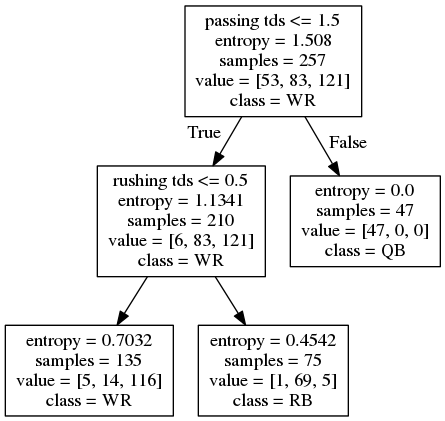

In [41]:
Image(filename='tree4.png')

This tree is much simpler and makes sense.  Immediately QBs are sorted out because they are the only players to accumulate meaningful passing touchdowns.  It appears that every QB is sorted correctly according to that entropy value given on the right.  Running backs and wide receivers are sorted through quickly based on rushing touchdowns.

This is probably where I will leave this assignment, for now.  There are many things to explore.  We could go back to the previous trees but add constraints to them so that they do not strive for 100% accuracy.  A difficult problem would be how to sort out TEs from WRs, as they have similar receiving stat structure.  The difficulty there is that blocking stats aren't really a thing.  Maybe one would have to combine TEs and WRs as a single class.

Other things we could work on: finding and improving general model accuracy, adding defensive players, ...

If you have questions email me at ajkerr0@gmail.com